# Feature engineering 2

In previous notebooks we performed a number of processing steps before making predictions namely OHE, normalisation and imputation.

Whilst these steps are necessary for some machine learning models (including neural networks) they are not all needed for LSTM. In this notebook we initially train an out-of-the-box LGBM after only one hot encoding the data and see how it performs.

We then explore the additional data sources provided and incorporate these.

## Set-up

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
os.chdir('..')

In [3]:
from src.data.utils import COLUMN_DESCRIPTION_DICT

In [4]:
pd.options.display.max_columns = None

## Prepare data

In [5]:
train = pd.read_csv('data/external/application_train.csv')
print(train.shape)

(307511, 122)


In [6]:
test = pd.read_csv('data/external/application_test.csv')
print(test.shape)

(48744, 121)


In [7]:
train['is_train_orig'] = 1
test['is_train_orig'] = 0

### Combine all the training and test data and then OHE:

In [8]:
combined = train.append(test)

In [9]:
combined.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,is_train_orig
0,100002,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1
1,100003,0.0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,100004,0.0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [10]:
object_columns = combined.select_dtypes(include=object).columns
len(object_columns)

16

In [11]:
combined= pd.get_dummies(combined, dummy_na=True, columns=object_columns)
# Remove non-alphanumeric characters in column names (otherwise LGBM errors)
combined.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in combined.columns]

In [12]:
train = combined.copy()[combined['is_train_orig'] == 1]
train.drop(['is_train_orig'], axis=1, inplace=True)
train.shape

(307511, 262)

In [13]:
test_kaggle = combined.copy()[combined['is_train_orig'] == 0]
test_kaggle.drop(['is_train_orig'], axis=1, inplace=True)
test_kaggle.shape

(48744, 262)

### Train/dev/test split available training data

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
train, test = train_test_split(train, test_size=0.2, random_state=42)

In [16]:
train, dev = train_test_split(train, test_size=0.25, random_state=42)

## Fit model

In [17]:
import lightgbm

In [18]:
X_train = train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y_train = train['TARGET']

In [19]:
lgbm = lightgbm.LGBMClassifier()

In [20]:
lgbm.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [21]:
training_predictions = lgbm.predict_proba(X_train)[:,1]

In [22]:
from sklearn.metrics import roc_auc_score

In [23]:
roc_auc_score(y_train, training_predictions)

0.8136778518219017

In [24]:
X_dev = dev.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y_dev = dev['TARGET']

In [25]:
dev_predictions = lgbm.predict_proba(X_dev)[:,1]

In [26]:
roc_auc_score(y_dev, dev_predictions)

0.7488730085435463

### Make submission with this very simple model

In [27]:
test_kaggle.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash_loans,NAME_CONTRACT_TYPE_Revolving_loans,NAME_CONTRACT_TYPE_nan,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,CODE_GENDER_nan,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_CAR_nan,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,FLAG_OWN_REALTY_nan,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group_of_people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,NAME_TYPE_SUITE_Spouse__partner,NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_nan,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial_associate,NAME_INCOME_TYPE_Maternity_leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State_servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_INCOME_TYPE_nan,NAME_EDUCATION_TYPE_Academic_degree,NAME_EDUCATION_TYPE_Higher_education,NAME_EDUCATION_TYPE_Incomplete_higher,NAME_EDUCATION_TYPE_Lower_secondary,NAME_EDUCATION_TYPE_Secondary___secondary_special,NAME_EDUCATION_TYPE_nan,NAME_FAMILY_STATUS_Civil_marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single___not_married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_FAMILY_STATUS_nan,NAME_HOUSING_TYPE_Co_op_apartment,NAME_HOUSING_TYPE_House___apartment,NAME_HOUSING_TYPE_Municipal_apartment,NAME_HOUSING_TYPE_Office_apartment,NAME_HOUSING_TYPE_Rented_apartment,NAME_HOUSING_TYPE_With_parents,NAME_HOUSING_TYPE_nan,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning_staff,OCCUPATION_TYPE_Cooking_staff,OCCUPATION_TYPE_Core_staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR_staff,OCCUPATION_TYPE_High_skill_tech_staff,OCCUPATION_TYPE_IT_staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low_skill_Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine_staff,OCCUPATION_TYPE_Private_service_staff,OCCUPATION_TYPE_Realty_agents,OCCUPATION_TYPE_Sales_staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security_staff,OCCUPATION_TYPE_Waiters_barmen_staff,OCCUPATION_TYPE_nan,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_

In [28]:
X_test_kaggle = test_kaggle.drop(['SK_ID_CURR', 'TARGET'], axis=1)

In [29]:
test_kaggle_predictions = lgbm.predict_proba(X_test_kaggle)[:, 1]

In [30]:
test_kaggle['TARGET'] = test_kaggle_predictions
test_kaggle.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash_loans,NAME_CONTRACT_TYPE_Revolving_loans,NAME_CONTRACT_TYPE_nan,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,CODE_GENDER_nan,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_CAR_nan,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,FLAG_OWN_REALTY_nan,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group_of_people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,NAME_TYPE_SUITE_Spouse__partner,NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_nan,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial_associate,NAME_INCOME_TYPE_Maternity_leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State_servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_INCOME_TYPE_nan,NAME_EDUCATION_TYPE_Academic_degree,NAME_EDUCATION_TYPE_Higher_education,NAME_EDUCATION_TYPE_Incomplete_higher,NAME_EDUCATION_TYPE_Lower_secondary,NAME_EDUCATION_TYPE_Secondary___secondary_special,NAME_EDUCATION_TYPE_nan,NAME_FAMILY_STATUS_Civil_marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single___not_married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_FAMILY_STATUS_nan,NAME_HOUSING_TYPE_Co_op_apartment,NAME_HOUSING_TYPE_House___apartment,NAME_HOUSING_TYPE_Municipal_apartment,NAME_HOUSING_TYPE_Office_apartment,NAME_HOUSING_TYPE_Rented_apartment,NAME_HOUSING_TYPE_With_parents,NAME_HOUSING_TYPE_nan,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning_staff,OCCUPATION_TYPE_Cooking_staff,OCCUPATION_TYPE_Core_staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR_staff,OCCUPATION_TYPE_High_skill_tech_staff,OCCUPATION_TYPE_IT_staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low_skill_Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine_staff,OCCUPATION_TYPE_Private_service_staff,OCCUPATION_TYPE_Realty_agents,OCCUPATION_TYPE_Sales_staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security_staff,OCCUPATION_TYPE_Waiters_barmen_staff,OCCUPATION_TYPE_nan,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_

In [31]:
test_kaggle[['SK_ID_CURR', 'TARGET']].to_csv('data/processed/simple_lgbm_submission.csv', index=False)

In [32]:
!kaggle competitions submit -c home-credit-default-risk -f data/processed/simple_lgbm_submission.csv -m "LGBM with feature engineering 1 pipeline after bug fix"

100%|███████████████████████████████████████| 1.26M/1.26M [00:07<00:00, 166kB/s]
Successfully submitted to Home Credit Default Risk

Public score: 0.73987

Private score: 0.73979

Best private score of all models submitted so far and public score only marginally lower than highest. Quite embarrassing!

## Quick shap plot for simple model

In [33]:
import shap

In [34]:
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_train)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Now need to selected shap values corresponding to second array i.e. shap values for probability predictions

### SHAP for model used in `05-Feature engineering 1` (DO NOT RUN CELL)

In [35]:
#shap.summary_plot(shap_values[1], input_df)

### SHAP for simple model

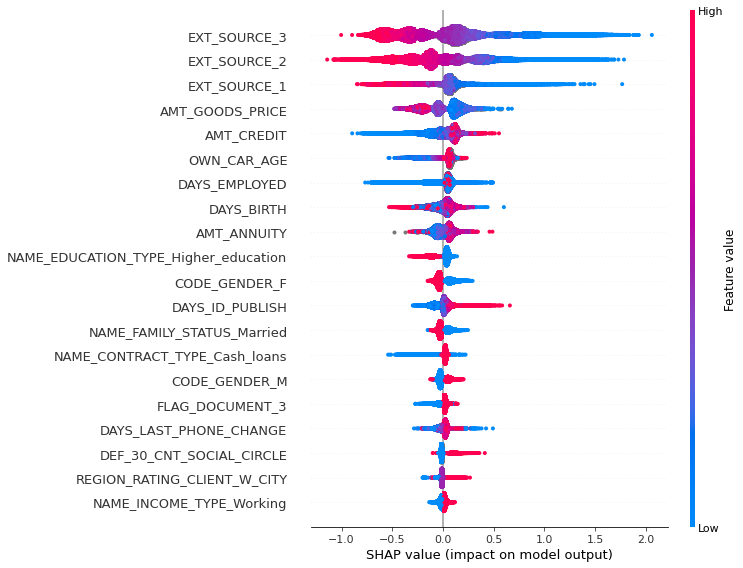

In [36]:
shap.summary_plot(shap_values[1], X_train)

Looks like the simple model is able to extract more value from `EXT_SOURCE_1`. This is a good sign because we would expect the 3 external data sources to be highly predictive.

## What is change in performance if we do feature scaling?

In [37]:
from sklearn.preprocessing import MinMaxScaler

In [38]:
min_max_scalar = MinMaxScaler()

In [39]:
X_train_scaled = min_max_scalar.fit_transform(X_train)
X_train_scaled.shape

(184506, 260)

In [40]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_train_scaled.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash_loans,NAME_CONTRACT_TYPE_Revolving_loans,NAME_CONTRACT_TYPE_nan,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,CODE_GENDER_nan,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_CAR_nan,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,FLAG_OWN_REALTY_nan,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group_of_people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,NAME_TYPE_SUITE_Spouse__partner,NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_nan,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial_associate,NAME_INCOME_TYPE_Maternity_leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State_servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_INCOME_TYPE_nan,NAME_EDUCATION_TYPE_Academic_degree,NAME_EDUCATION_TYPE_Higher_education,NAME_EDUCATION_TYPE_Incomplete_higher,NAME_EDUCATION_TYPE_Lower_secondary,NAME_EDUCATION_TYPE_Secondary___secondary_special,NAME_EDUCATION_TYPE_nan,NAME_FAMILY_STATUS_Civil_marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single___not_married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_FAMILY_STATUS_nan,NAME_HOUSING_TYPE_Co_op_apartment,NAME_HOUSING_TYPE_House___apartment,NAME_HOUSING_TYPE_Municipal_apartment,NAME_HOUSING_TYPE_Office_apartment,NAME_HOUSING_TYPE_Rented_apartment,NAME_HOUSING_TYPE_With_parents,NAME_HOUSING_TYPE_nan,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning_staff,OCCUPATION_TYPE_Cooking_staff,OCCUPATION_TYPE_Core_staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR_staff,OCCUPATION_TYPE_High_skill_tech_staff,OCCUPATION_TYPE_IT_staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low_skill_Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine_staff,OCCUPATION_TYPE_Private_service_staff,OCCUPATION_TYPE_Realty_agents,OCCUPATION_TYPE_Sales_staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security_staff,OCCUPATION_TYPE_Waiters_barmen_staff,OCCUPATION_TYPE_nan,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THUR

In [41]:
lgbm_on_scaled = lightgbm.LGBMClassifier()

In [42]:
lgbm_on_scaled.fit(X_train_scaled, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [43]:
training_predictions = lgbm_on_scaled.predict_proba(X_train_scaled)[:,1]

In [44]:
roc_auc_score(y_train, training_predictions)

0.8135727416979284

In [45]:
X_dev_scaled = min_max_scalar.transform(X_dev)
X_dev_scaled = pd.DataFrame(X_dev_scaled, columns=X_dev.columns)

In [46]:
dev_predictions = lgbm_on_scaled.predict_proba(X_dev_scaled)[:,1]

In [47]:
roc_auc_score(y_dev, dev_predictions)

0.7496568884523257

0.0001 worse on training set

0.0008 better on dev set

Maybe worth implementing given we care more about performance on the dev set.

## What is change in performance if we do null imputation?

Note this will only take effect for numerical variables since we included dummies for null categorical variables when we performed OHE

In [48]:
from sklearn.impute import SimpleImputer

In [49]:
mean_imputer = SimpleImputer(strategy='mean')

In [50]:
X_train_imputed = mean_imputer.fit_transform(X_train)
X_train_imputed.shape

(184506, 260)

In [51]:
X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train.columns)
X_train_imputed.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash_loans,NAME_CONTRACT_TYPE_Revolving_loans,NAME_CONTRACT_TYPE_nan,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,CODE_GENDER_nan,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_CAR_nan,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,FLAG_OWN_REALTY_nan,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group_of_people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,NAME_TYPE_SUITE_Spouse__partner,NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_nan,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial_associate,NAME_INCOME_TYPE_Maternity_leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State_servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_INCOME_TYPE_nan,NAME_EDUCATION_TYPE_Academic_degree,NAME_EDUCATION_TYPE_Higher_education,NAME_EDUCATION_TYPE_Incomplete_higher,NAME_EDUCATION_TYPE_Lower_secondary,NAME_EDUCATION_TYPE_Secondary___secondary_special,NAME_EDUCATION_TYPE_nan,NAME_FAMILY_STATUS_Civil_marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single___not_married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_FAMILY_STATUS_nan,NAME_HOUSING_TYPE_Co_op_apartment,NAME_HOUSING_TYPE_House___apartment,NAME_HOUSING_TYPE_Municipal_apartment,NAME_HOUSING_TYPE_Office_apartment,NAME_HOUSING_TYPE_Rented_apartment,NAME_HOUSING_TYPE_With_parents,NAME_HOUSING_TYPE_nan,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning_staff,OCCUPATION_TYPE_Cooking_staff,OCCUPATION_TYPE_Core_staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR_staff,OCCUPATION_TYPE_High_skill_tech_staff,OCCUPATION_TYPE_IT_staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low_skill_Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine_staff,OCCUPATION_TYPE_Private_service_staff,OCCUPATION_TYPE_Realty_agents,OCCUPATION_TYPE_Sales_staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security_staff,OCCUPATION_TYPE_Waiters_barmen_staff,OCCUPATION_TYPE_nan,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THUR

In [52]:
lgbm_on_imputed = lightgbm.LGBMClassifier()

In [53]:
lgbm_on_imputed.fit(X_train_imputed, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [54]:
training_predictions = lgbm_on_imputed.predict_proba(X_train_imputed)[:,1]

In [55]:
roc_auc_score(y_train, training_predictions)

0.8112052079584662

In [56]:
X_dev_imputed = mean_imputer.transform(X_dev)
X_dev_imputed = pd.DataFrame(X_dev_imputed, columns=X_dev.columns)

In [57]:
dev_predictions = lgbm_on_imputed.predict_proba(X_dev_imputed)[:,1]

In [58]:
roc_auc_score(y_dev, dev_predictions)

0.7501487277504515

0.0024 worse on training set

0.0013 better on dev set

Maybe worth implementing given we care more about performance on the dev set.

## Look at other data

![](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)

In [59]:
bureau = pd.read_csv('data/external/bureau.csv')
print(bureau.shape)
bureau.head()

(1716428, 17)


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [68]:
bureau['SK_ID_CURR'].nunique()

305811

In [69]:
bureau['SK_ID_BUREAU'].nunique()

1716428

In [60]:
COLUMN_DESCRIPTION_DICT.keys()

dict_keys(['POS_CASH_balance.csv', 'application_{train|test}.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'installments_payments.csv', 'previous_application.csv'])

In [61]:
bureau_dict = COLUMN_DESCRIPTION_DICT['bureau.csv']

In [62]:
bureau_dict['DAYS_CREDIT']

{'Description': 'How many days before current application did client apply for Credit Bureau credit',
 'Special': 'time only relative to the application'}

In [63]:
bureau_balance = pd.read_csv('data/external/bureau_balance.csv')
print(bureau_balance.shape)
bureau_balance.head()

(27299925, 3)


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [64]:
bureau_balance_dict = COLUMN_DESCRIPTION_DICT['bureau_balance.csv']

In [65]:
print(bureau_balance_dict['STATUS']['Description'])

Status of Credit Bureau loan during the month (active, closed, DPD0-30, [C means closed, X means status unknown, 0 means no DPD, 1 means maximal did during month between 1-30, 2 means DPD 31-60, 5 means DPD 120+ or sold or written off ] )


In [66]:
print(bureau_balance_dict['MONTHS_BALANCE'])

{'Description': 'Month of balance relative to application date (-1 means the freshest balance date)', 'Special': 'time only relative to the application'}


In [67]:
bureau_balance['STATUS'].value_counts(dropna=False)

C    13646993
0     7499507
X     5810482
1      242347
5       62406
2       23419
3        8924
4        5847
Name: STATUS, dtype: int64

In [71]:
bureau_balance['MONTHS_BALANCE'].min()

-96

In [72]:
bureau_balance_temp = bureau_balance.copy()

In [75]:
bureau_balance_temp = pd.get_dummies(bureau_balance_temp, columns=['STATUS'])
bureau_balance_temp.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS_0,STATUS_1,STATUS_2,STATUS_3,STATUS_4,STATUS_5,STATUS_C,STATUS_X
0,5715448,0,0,0,0,0,0,0,1,0
1,5715448,-1,0,0,0,0,0,0,1,0
2,5715448,-2,0,0,0,0,0,0,1,0
3,5715448,-3,0,0,0,0,0,0,1,0
4,5715448,-4,0,0,0,0,0,0,1,0


### Total statuses over history of loan (e.g. total times went 1 down)

In [83]:
bureau_balance_temp['MONTH_COUNT'] = 1

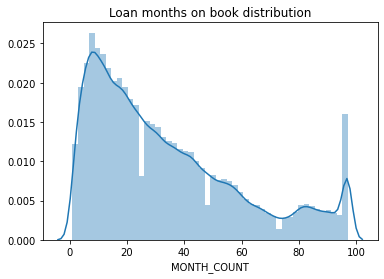

In [88]:
plt.title('Loan months on book distribution')
sns.distplot(bureau_balance_temp.groupby('SK_ID_BUREAU').sum()['MONTH_COUNT'])

In [91]:
bureau_balance_temp_sum = bureau_balance_temp.groupby('SK_ID_BUREAU').sum().reset_index()
bureau_balance_temp_sum.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS_0,STATUS_1,STATUS_2,STATUS_3,STATUS_4,STATUS_5,STATUS_C,STATUS_X,MONTH_COUNT
0,5001709,-4656,0,0,0,0,0,0,86,11,97
1,5001710,-3403,5,0,0,0,0,0,48,30,83
2,5001711,-6,3,0,0,0,0,0,0,1,4
3,5001712,-171,10,0,0,0,0,0,9,0,19
4,5001713,-231,0,0,0,0,0,0,0,22,22


In [101]:
column_rename_dict = dict(
    zip(
        [x for x in bureau_balance_temp.columns if 'STATUS' in x],
        [f'total_{x}' for x in bureau_balance_temp.columns if 'STATUS' in x]
    )
)

bureau_balance_temp_sum.rename(columns=column_rename_dict, inplace=True)
bureau_balance_temp_sum.head()

,SK_ID_BUREAU,MONTHS_BALANCE,total_STATUS_0,total_STATUS_1,total_STATUS_2,total_STATUS_3,total_STATUS_4,total_STATUS_5,total_STATUS_C,total_STATUS_X,MONTH_COUNT
0,5001709,-4656,0,0,0,0,0,0,86,11,97
1,5001710,-3403,5,0,0,0,0,0,48,30,83
2,5001711,-6,3,0,0,0,0,0,0,1,4
3,5001712,-171,10,0,0,0,0,0,9,0,19
4,5001713,-231,0,0,0,0,0,0,0,22,22


In [114]:
total_statuses_df = bureau_balance_temp_sum.drop('MONTHS_BALANCE', axis=1)
total_statuses_df.head()

,SK_ID_BUREAU,total_STATUS_0,total_STATUS_1,total_STATUS_2,total_STATUS_3,total_STATUS_4,total_STATUS_5,total_STATUS_C,total_STATUS_X,MONTH_COUNT
0,5001709,0,0,0,0,0,0,86,11,97
1,5001710,5,0,0,0,0,0,48,30,83
2,5001711,3,0,0,0,0,0,0,1,4
3,5001712,10,0,0,0,0,0,9,0,19
4,5001713,0,0,0,0,0,0,0,22,22


In [144]:
bureau_balance[bureau_balance['SK_ID_BUREAU'] == 5001709].tail(11)

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
26079839,5001709,-86,X
26079840,5001709,-87,X
26079841,5001709,-88,X
26079842,5001709,-89,X
26079843,5001709,-90,X
26079844,5001709,-91,X
26079845,5001709,-92,X
26079846,5001709,-93,X
26079847,5001709,-94,X
26079848,5001709,-95,X


In [145]:
# Drop total_STATUS_C (once closed state doesn't age) and 'total_STATUS_X' (looks like X status might always be consecutive)
# For statuses 0 to 5 loans would roll between statuses. May be useful to know how many times someone went 1 down etc.

total_statuses_df.drop(['total_STATUS_C', 'total_STATUS_X'], axis=1, inplace=True)

### Latest loan status

In [103]:
bureau_balance_temp.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS_0,STATUS_1,STATUS_2,STATUS_3,STATUS_4,STATUS_5,STATUS_C,STATUS_X,MONTH_COUNT
0,5715448,0,0,0,0,0,0,0,1,0,1
1,5715448,-1,0,0,0,0,0,0,1,0,1
2,5715448,-2,0,0,0,0,0,0,1,0,1
3,5715448,-3,0,0,0,0,0,0,1,0,1
4,5715448,-4,0,0,0,0,0,0,1,0,1


In [119]:
most_recent_months_balance = bureau_balance_temp.groupby('SK_ID_BUREAU').max()['MONTHS_BALANCE'].reset_index()

In [124]:
latest_loan_status = bureau_balance_temp.merge(most_recent_months_balance, on=['SK_ID_BUREAU', 'MONTHS_BALANCE'], how='inner')
print(latest_loan_status.shape)
latest_loan_status.head()

(817395, 11)


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS_0,STATUS_1,STATUS_2,STATUS_3,STATUS_4,STATUS_5,STATUS_C,STATUS_X,MONTH_COUNT
0,5715448,0,0,0,0,0,0,0,1,0,1
1,5715449,0,0,0,0,0,0,0,1,0,1
2,5715451,-5,0,0,0,0,0,0,1,0,1
3,5715452,0,0,0,0,0,0,0,1,0,1
4,5715453,0,0,0,0,0,0,0,1,0,1


In [123]:
bureau_balance['SK_ID_BUREAU'].nunique()

817395

In [125]:
latest_loan_status['age_of_latest_bureau_loan_status'] = -latest_loan_status['MONTHS_BALANCE']

In [126]:
column_rename_dict = dict(
    zip(
        [x for x in latest_loan_status.columns if 'STATUS' in x],
        [f'latest_{x}' for x in latest_loan_status.columns if 'STATUS' in x]
    )
)

latest_loan_status.rename(columns=column_rename_dict, inplace=True)
latest_loan_status.head()

,SK_ID_BUREAU,MONTHS_BALANCE,latest_STATUS_0,latest_STATUS_1,latest_STATUS_2,latest_STATUS_3,latest_STATUS_4,latest_STATUS_5,latest_STATUS_C,latest_STATUS_X,MONTH_COUNT,age_of_latest_bureau_loan_status
0,5715448,0,0,0,0,0,0,0,1,0,1,0
1,5715449,0,0,0,0,0,0,0,1,0,1,0
2,5715451,-5,0,0,0,0,0,0,1,0,1,5
3,5715452,0,0,0,0,0,0,0,1,0,1,0
4,5715453,0,0,0,0,0,0,0,1,0,1,0


In [ ]:
np.where(
    latest_loan_status['']
)

In [132]:
latest_loan_status['latest_in_arrears'] = np.where(
    latest_loan_status[['latest_STATUS_2', 'latest_STATUS_3', 'latest_STATUS_4', 'latest_STATUS_5']].sum(axis=1) > 0,
    1,
    0
)

In [133]:
latest_loan_status['latest_in_arrears'].value_counts()

0    815702
1      1693
Name: latest_in_arrears, dtype: int64

In [134]:
latest_loan_status.head()

,SK_ID_BUREAU,MONTHS_BALANCE,latest_STATUS_0,latest_STATUS_1,latest_STATUS_2,latest_STATUS_3,latest_STATUS_4,latest_STATUS_5,latest_STATUS_C,latest_STATUS_X,MONTH_COUNT,age_of_latest_bureau_loan_status,latest_in_arrears
0,5715448,0,0,0,0,0,0,0,1,0,1,0,0
1,5715449,0,0,0,0,0,0,0,1,0,1,0,0
2,5715451,-5,0,0,0,0,0,0,1,0,1,5,0
3,5715452,0,0,0,0,0,0,0,1,0,1,0,0
4,5715453,0,0,0,0,0,0,0,1,0,1,0,0


In [135]:
latest_loan_status.drop(['MONTHS_BALANCE', 'MONTH_COUNT'], axis=1, inplace=True)

In [136]:
# Let's define 4 or 5 down as being in default

latest_loan_status['latest_in_default'] = np.where(
    (latest_loan_status['latest_STATUS_4'] == 1) | (latest_loan_status['latest_STATUS_5'] == 1),
    1,
    0
)

In [138]:
latest_loan_status['latest_in_default'].value_counts()

0    816074
1      1321
Name: latest_in_default, dtype: int64

### Merge new features extracted using bureau_balance

In [147]:
print(total_statuses_df.shape)
total_statuses_df.head()

(817395, 8)


,SK_ID_BUREAU,total_STATUS_0,total_STATUS_1,total_STATUS_2,total_STATUS_3,total_STATUS_4,total_STATUS_5,MONTH_COUNT
0,5001709,0,0,0,0,0,0,97
1,5001710,5,0,0,0,0,0,83
2,5001711,3,0,0,0,0,0,4
3,5001712,10,0,0,0,0,0,19
4,5001713,0,0,0,0,0,0,22


In [148]:
print(latest_loan_status.shape)
latest_loan_status.head()

(817395, 12)


,SK_ID_BUREAU,latest_STATUS_0,latest_STATUS_1,latest_STATUS_2,latest_STATUS_3,latest_STATUS_4,latest_STATUS_5,latest_STATUS_C,latest_STATUS_X,age_of_latest_bureau_loan_status,latest_in_arrears,latest_in_default
0,5715448,0,0,0,0,0,0,1,0,0,0,0
1,5715449,0,0,0,0,0,0,1,0,0,0,0
2,5715451,0,0,0,0,0,0,1,0,5,0,0
3,5715452,0,0,0,0,0,0,1,0,0,0,0
4,5715453,0,0,0,0,0,0,1,0,0,0,0


In [149]:
bureau_balance_features = total_statuses_df.merge(latest_loan_status, on='SK_ID_BUREAU', how='inner')
bureau_balance_features.shape

(817395, 19)

### Merge onto bureau data

Can now merge this 1:1 with `bureau.csv`

In [172]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,CREDIT_TYPE_CATEGORY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN,Consumer credit
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN,Credit card
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN,Consumer credit
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN,Credit card
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN,Consumer credit


In [173]:
bureau_dict['CREDIT_ACTIVE']

{'Description': 'Status of the Credit Bureau (CB) reported credits',
 'Special': nan}

In [174]:
bureau['CREDIT_ACTIVE'].value_counts(dropna=False)

Closed      1079273
Active       630607
Sold           6527
Bad debt         21
Name: CREDIT_ACTIVE, dtype: int64

In [175]:
bureau['CREDIT_TYPE'].value_counts(dropna=False)

Consumer credit                                 1251615
Credit card                                      402195
Car loan                                          27690
Mortgage                                          18391
Microloan                                         12413
Loan for business development                      1975
Another type of loan                               1017
Unknown type of loan                                555
Loan for working capital replenishment              469
Cash loan (non-earmarked)                            56
Real estate loan                                     27
Loan for the purchase of equipment                   19
Loan for purchase of shares (margin lending)          4
Interbank credit                                      1
Mobile operator loan                                  1
Name: CREDIT_TYPE, dtype: int64

In [176]:
bureau['CREDIT_TYPE_CATEGORY'] = np.where(
    bureau['CREDIT_TYPE'].isin(['Consumer credit', 'Credit card', 'Car loan', 'Mortgage', 'Microloan', 'Loan for business development']),
    bureau['CREDIT_TYPE'],
    'Other'
)

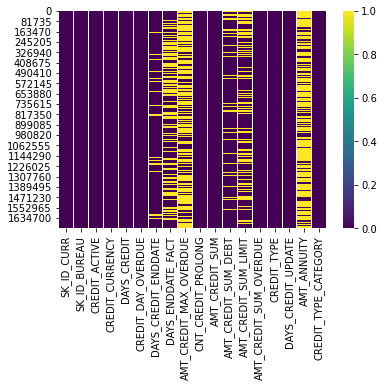

In [162]:
sns.heatmap(bureau.isnull(), cmap='viridis')

In [177]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,CREDIT_TYPE_CATEGORY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN,Consumer credit
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN,Credit card
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN,Consumer credit
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN,Credit card
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN,Consumer credit


In [178]:
object_columns = bureau.select_dtypes(include=object).columns
len(object_columns)

4

For object columns we OHE then groupby().sum() to get counts

For numeric columns compute: groupby().sum()/.mean()/.min()/.max() - Can discard features later if not useful

In [197]:
bureau_object_data = pd.get_dummies(bureau[['SK_ID_CURR', 'SK_ID_BUREAU'] + list(object_columns)], columns=object_columns)
bureau_object_data.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,CREDIT_TYPE_Cash loan (non-earmarked),CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Interbank credit,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,CREDIT_TYPE_CATEGORY_Car loan,CREDIT_TYPE_CATEGORY_Consumer credit,CREDIT_TYPE_CATEGORY_Credit card,CREDIT_TYPE_CATEGORY_Loan for business development,CREDIT_TYPE_CATEGORY_Microloan,CREDIT_TYPE_CATEGORY_Mortgage,CREDIT_TYPE_CATEGORY_Other
0,215354,5714462,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,215354,5714463,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,215354,5714464,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,215354,5714465,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,215354,5714466,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [200]:
bureau_object_data = bureau_object_data.groupby('SK_ID_CURR').sum().reset_index()
bureau_object_data.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,CREDIT_TYPE_Cash loan (non-earmarked),CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Interbank credit,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,CREDIT_TYPE_CATEGORY_Car loan,CREDIT_TYPE_CATEGORY_Consumer credit,CREDIT_TYPE_CATEGORY_Credit card,CREDIT_TYPE_CATEGORY_Loan for business development,CREDIT_TYPE_CATEGORY_Microloan,CREDIT_TYPE_CATEGORY_Mortgage,CREDIT_TYPE_CATEGORY_Other
0,100001,41276431,3,0,4,0,7,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0
1,100002,49226177,2,0,6,0,8,0,0,0,0,0,0,4,4,0,0,0,0,0,0,0,0,0,0,0,4,4,0,0,0,0
2,100003,23543514,1,0,3,0,4,0,0,0,0,0,0,2,2,0,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0
3,100004,13658267,0,0,2,0,2,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0
4,100005,20205603,2,0,1,0,3,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0


In [201]:
bureau_object_data.columns = ['COUNT_' + col for col in bureau_object_data.columns]
bureau_object_data.drop('COUNT_SK_ID_BUREAU', axis=1, inplace=True)
bureau_object_data.rename(columns={'COUNT_SK_ID_CURR': 'SK_ID_CURR'}, inplace=True)
print(bureau_object_data.shape)
bureau_object_data.head()

(305811, 31)


,SK_ID_CURR,COUNT_CREDIT_ACTIVE_Active,COUNT_CREDIT_ACTIVE_Bad debt,COUNT_CREDIT_ACTIVE_Closed,COUNT_CREDIT_ACTIVE_Sold,COUNT_CREDIT_CURRENCY_currency 1,COUNT_CREDIT_CURRENCY_currency 2,COUNT_CREDIT_CURRENCY_currency 3,COUNT_CREDIT_CURRENCY_currency 4,COUNT_CREDIT_TYPE_Another type of loan,COUNT_CREDIT_TYPE_Car loan,COUNT_CREDIT_TYPE_Cash loan (non-earmarked),COUNT_CREDIT_TYPE_Consumer credit,COUNT_CREDIT_TYPE_Credit card,COUNT_CREDIT_TYPE_Interbank credit,COUNT_CREDIT_TYPE_Loan for business development,COUNT_CREDIT_TYPE_Loan for purchase of shares (margin lending),COUNT_CREDIT_TYPE_Loan for the purchase of equipment,COUNT_CREDIT_TYPE_Loan for working capital replenishment,COUNT_CREDIT_TYPE_Microloan,COUNT_CREDIT_TYPE_Mobile operator loan,COUNT_CREDIT_TYPE_Mortgage,COUNT_CREDIT_TYPE_Real estate loan,COUNT_CREDIT_TYPE_Unknown type of loan,COUNT_CREDIT_TYPE_CATEGORY_Car loan,COUNT_CREDIT_TYPE_CATEGORY_Consumer credit,COUNT_CREDIT_TYPE_CATEGORY_Credit card,COUNT_CREDIT_TYPE_CATEGORY_Loan for business development,COUNT_CREDIT_TYPE_CATEGORY_Microloan,COUNT_CREDIT_TYPE_CATEGORY_Mortgage,COUNT_CREDIT_TYPE_CATEGORY_Other
0,100001,3,0,4,0,7,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0
1,100002,2,0,6,0,8,0,0,0,0,0,0,4,4,0,0,0,0,0,0,0,0,0,0,0,4,4,0,0,0,0
2,100003,1,0,3,0,4,0,0,0,0,0,0,2,2,0,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0
3,100004,0,0,2,0,2,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0
4,100005,2,0,1,0,3,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0


In [203]:
bureau['SK_ID_CURR'].nunique()

305811

Numeric columns

In [204]:
# Add bureau balance features
bureau_full = bureau.merge(bureau_balance_features, on='SK_ID_BUREAU', how='left')
print(bureau_full.shape)
bureau_full.head()

(1716428, 36)


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,CREDIT_TYPE_CATEGORY,total_STATUS_0,total_STATUS_1,total_STATUS_2,total_STATUS_3,total_STATUS_4,total_STATUS_5,MONTH_COUNT,latest_STATUS_0,latest_STATUS_1,latest_STATUS_2,latest_STATUS_3,latest_STATUS_4,latest_STATUS_5,latest_STATUS_C,latest_STATUS_X,age_of_latest_bureau_loan_status,latest_in_arrears,latest_in_default
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN,Consumer credit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN,Credit card,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN,Consumer credit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN,Credit card,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN,Consumer credit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [206]:
bureau_full.drop(object_columns, axis=1, inplace=True)

In [212]:
sum_data = bureau_full.groupby('SK_ID_CURR').sum().reset_index().drop('SK_ID_BUREAU', axis=1)
sum_data.columns = [sum_data.columns[0]] + ['SUM_' + col for col in sum_data.columns[1:]]

In [229]:
mean_data = bureau_full.groupby('SK_ID_CURR').mean().reset_index().drop('SK_ID_BUREAU', axis=1)
mean_data.columns = [mean_data.columns[0]] + ['MEAN_' + col for col in mean_data.columns[1:]]

In [233]:
max_data = bureau_full.groupby('SK_ID_CURR').max().reset_index().drop('SK_ID_BUREAU', axis=1)
max_data.columns = [max_data.columns[0]] + ['MAX_' + col for col in max_data.columns[1:]]

In [235]:
min_data = bureau_full.groupby('SK_ID_CURR').min().reset_index().drop('SK_ID_BUREAU', axis=1)
min_data.columns = [min_data.columns[0]] + ['MIN_' + col for col in min_data.columns[1:]]

In [238]:
from functools import reduce

In [240]:
dfs = [sum_data, mean_data, min_data, max_data]
bureau_numeric_data = reduce(lambda left,right: pd.merge(left, right, on='SK_ID_CURR'), dfs)
print(bureau_numeric_data.shape)
bureau_numeric_data.head()

(305811, 121)


,SK_ID_CURR,SUM_DAYS_CREDIT,SUM_CREDIT_DAY_OVERDUE,SUM_DAYS_CREDIT_ENDDATE,SUM_DAYS_ENDDATE_FACT,SUM_AMT_CREDIT_MAX_OVERDUE,SUM_CNT_CREDIT_PROLONG,SUM_AMT_CREDIT_SUM,SUM_AMT_CREDIT_SUM_DEBT,SUM_AMT_CREDIT_SUM_LIMIT,SUM_AMT_CREDIT_SUM_OVERDUE,SUM_DAYS_CREDIT_UPDATE,SUM_AMT_ANNUITY,SUM_total_STATUS_0,SUM_total_STATUS_1,SUM_total_STATUS_2,SUM_total_STATUS_3,SUM_total_STATUS_4,SUM_total_STATUS_5,SUM_MONTH_COUNT,SUM_latest_STATUS_0,SUM_latest_STATUS_1,SUM_latest_STATUS_2,SUM_latest_STATUS_3,SUM_latest_STATUS_4,SUM_latest_STATUS_5,SUM_latest_STATUS_C,SUM_latest_STATUS_X,SUM_age_of_latest_bureau_loan_status,SUM_latest_in_arrears,SUM_latest_in_default,MEAN_DAYS_CREDIT,MEAN_CREDIT_DAY_OVERDUE,MEAN_DAYS_CREDIT_ENDDATE,MEAN_DAYS_ENDDATE_FACT,MEAN_AMT_CREDIT_MAX_OVERDUE,MEAN_CNT_CREDIT_PROLONG,MEAN_AMT_CREDIT_SUM,MEAN_AMT_CREDIT_SUM_DEBT,MEAN_AMT_CREDIT_SUM_LIMIT,MEAN_AMT_CREDIT_SUM_OVERDUE,MEAN_DAYS_CREDIT_UPDATE,MEAN_AMT_ANNUITY,MEAN_total_STATUS_0,MEAN_total_STATUS_1,MEAN_total_STATUS_2,MEAN_total_STATUS_3,MEAN_total_STATUS_4,MEAN_total_STATUS_5,MEAN_MONTH_COUNT,MEAN_latest_STATUS_0,MEAN_latest_STATUS_1,MEAN_latest_STATUS_2,MEAN_latest_STATUS_3,MEAN_latest_STATUS_4,MEAN_latest_STATUS_5,MEAN_latest_STATUS_C,MEAN_latest_STATUS_X,MEAN_age_of_latest_bureau_loan_status,MEAN_latest_in_arrears,MEAN_latest_in_default,MIN_DAYS_CREDIT,MIN_CREDIT_DAY_OVERDUE,MIN_DAYS_CREDIT_ENDDATE,MIN_DAYS_ENDDATE_FACT,MIN_AMT_CREDIT_MAX_OVERDUE,MIN_CNT_CREDIT_PROLONG,MIN_AMT_CREDIT_SUM,MIN_AMT_CREDIT_SUM_DEBT,MIN_AMT_CREDIT_SUM_LIMIT,MIN_AMT_CREDIT_SUM_OVERDUE,MIN_DAYS_CREDIT_UPDATE,MIN_AMT_ANNUITY,MIN_total_STATUS_0,MIN_total_STATUS_1,MIN_total_STATUS_2,MIN_total_STATUS_3,MIN_total_STATUS_4,MIN_total_STATUS_5,MIN_MONTH_COUNT,MIN_latest_STATUS_0,MIN_latest_STATUS_1,MIN_latest_STATUS_2,MIN_latest_STATUS_3,MIN_latest_STATUS_4,MIN_latest_STATUS_5,MIN_latest_STATUS_C,MIN_latest_STATUS_X,MIN_age_of_latest_bureau_loan_status,MIN_latest_in_arrears,MIN_latest_in_default,MAX_DAYS_CREDIT,MAX_CREDIT_DAY_OVERDUE,MAX_DAYS_CREDIT_ENDDATE,MAX_DAYS_ENDDATE_FACT,MAX_AMT_CREDIT_MAX_OVERDUE,MAX_CNT_CREDIT_PROLONG,MAX_AMT_CREDIT_SUM,MAX_AMT_CREDIT_SUM_DEBT,MAX_AMT_CREDIT_SUM_LIMIT,MAX_AMT_CREDIT_SUM_OVERDUE,MAX_DAYS_CREDIT_UPDATE,MAX_AMT_ANNUITY,MAX_total_STATUS_0,MAX_total_STATUS_1,MAX_total_STATUS_2,MAX_total_STATUS_3,MAX_total_STATUS_4,MAX_total_STATUS_5,MAX_MONTH_COUNT,MAX_latest_STATUS_0,MAX_latest_STATUS_1,MAX_latest_STATUS_2,MAX_latest_STATUS_3,MAX_latest_STATUS_4,MAX_latest_STATUS_5,MAX_latest_STATUS_C,MAX_latest_STATUS_X,MAX_age_of_latest_bureau_loan_status,MAX_latest_in_arrears,MAX_latest_in_default
0,100001,-5145,0,577.0,-3302.0,0.000,0,1453365.000,596686.5,0.000,0.0,-652,24817.5,31.0,1.0,0.0,0.0,0.0,0.0,172.0,2.0,1.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,-735.000000,0.0,82.428571,-825.500000,NaN,0.0,207623.571429,85240.928571,0.00000,0.0,-93.142857,3545.357143,4.428571,0.142857,0.0,0.0,0.0,0.0,24.571429,0.285714,0.142857,0.0,0.0,0.0,0.0,0.571429,0.000000,0.0,0.0,0.0,-1572,0,-1329.0,-1328.0,NaN,0,85500.0,0.0,0.0,0.0,-155,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-49,0,1778.0,-544.0,NaN,0,378000.0,373239.0,0.000,0.0,-6,10822.5,12.0,1.0,0.0,0.0,0.0,0.0,52.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,100002,-6992,0,-2094.0,-4185.0,8405.145,0,865055.565,245781.0,31988.565,0.0,-3999,0.0,45.0,27.0,0.0,0.0,0.0,0.0,110.0,2.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,124.0,0.0,0.0,-874.000000,0.0,-349.000000,-697.500000,1681.029,0.0,108131.945625,49156.200000,7997.14125,0.0,-499.875000,0.000000,5.625000,3.375000,0.0,0.0,0.0,0.0,13.750000,0.250000,0.000000,0.0,0.0,0.0,0.0,0.750000,0.000000,15.5,0.0,0.0,-1437,0,-1072.0,-1185.0,0.0,0,0.0,0.0,0.0,0.0,-1185,0.0,2.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-103,0,780.0,-36.0,5043.645,0,450000.0,245781.0,31988.565,0.0,-7,0.0,18.0,6.0,0.0,0.0,0.0,0.0,22.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,32.0,0.0,0.0
2,100003,-5603,0,-2178.0,-3292.0,0.000,0,1017400.500,0.0,810000.000,0.0,-3264,0.0,0.0,0.0,0

### Put object and numeric data together

In [241]:
bureau_processed = bureau_numeric_data.merge(bureau_object_data, on='SK_ID_CURR', how='inner')
print(bureau_processed.shape)
bureau_processed.head()

(305811, 151)


,SK_ID_CURR,SUM_DAYS_CREDIT,SUM_CREDIT_DAY_OVERDUE,SUM_DAYS_CREDIT_ENDDATE,SUM_DAYS_ENDDATE_FACT,SUM_AMT_CREDIT_MAX_OVERDUE,SUM_CNT_CREDIT_PROLONG,SUM_AMT_CREDIT_SUM,SUM_AMT_CREDIT_SUM_DEBT,SUM_AMT_CREDIT_SUM_LIMIT,SUM_AMT_CREDIT_SUM_OVERDUE,SUM_DAYS_CREDIT_UPDATE,SUM_AMT_ANNUITY,SUM_total_STATUS_0,SUM_total_STATUS_1,SUM_total_STATUS_2,SUM_total_STATUS_3,SUM_total_STATUS_4,SUM_total_STATUS_5,SUM_MONTH_COUNT,SUM_latest_STATUS_0,SUM_latest_STATUS_1,SUM_latest_STATUS_2,SUM_latest_STATUS_3,SUM_latest_STATUS_4,SUM_latest_STATUS_5,SUM_latest_STATUS_C,SUM_latest_STATUS_X,SUM_age_of_latest_bureau_loan_status,SUM_latest_in_arrears,SUM_latest_in_default,MEAN_DAYS_CREDIT,MEAN_CREDIT_DAY_OVERDUE,MEAN_DAYS_CREDIT_ENDDATE,MEAN_DAYS_ENDDATE_FACT,MEAN_AMT_CREDIT_MAX_OVERDUE,MEAN_CNT_CREDIT_PROLONG,MEAN_AMT_CREDIT_SUM,MEAN_AMT_CREDIT_SUM_DEBT,MEAN_AMT_CREDIT_SUM_LIMIT,MEAN_AMT_CREDIT_SUM_OVERDUE,MEAN_DAYS_CREDIT_UPDATE,MEAN_AMT_ANNUITY,MEAN_total_STATUS_0,MEAN_total_STATUS_1,MEAN_total_STATUS_2,MEAN_total_STATUS_3,MEAN_total_STATUS_4,MEAN_total_STATUS_5,MEAN_MONTH_COUNT,MEAN_latest_STATUS_0,MEAN_latest_STATUS_1,MEAN_latest_STATUS_2,MEAN_latest_STATUS_3,MEAN_latest_STATUS_4,MEAN_latest_STATUS_5,MEAN_latest_STATUS_C,MEAN_latest_STATUS_X,MEAN_age_of_latest_bureau_loan_status,MEAN_latest_in_arrears,MEAN_latest_in_default,MIN_DAYS_CREDIT,MIN_CREDIT_DAY_OVERDUE,MIN_DAYS_CREDIT_ENDDATE,MIN_DAYS_ENDDATE_FACT,MIN_AMT_CREDIT_MAX_OVERDUE,MIN_CNT_CREDIT_PROLONG,MIN_AMT_CREDIT_SUM,MIN_AMT_CREDIT_SUM_DEBT,MIN_AMT_CREDIT_SUM_LIMIT,MIN_AMT_CREDIT_SUM_OVERDUE,MIN_DAYS_CREDIT_UPDATE,MIN_AMT_ANNUITY,MIN_total_STATUS_0,MIN_total_STATUS_1,MIN_total_STATUS_2,MIN_total_STATUS_3,MIN_total_STATUS_4,MIN_total_STATUS_5,MIN_MONTH_COUNT,MIN_latest_STATUS_0,MIN_latest_STATUS_1,MIN_latest_STATUS_2,MIN_latest_STATUS_3,MIN_latest_STATUS_4,MIN_latest_STATUS_5,MIN_latest_STATUS_C,MIN_latest_STATUS_X,MIN_age_of_latest_bureau_loan_status,MIN_latest_in_arrears,MIN_latest_in_default,MAX_DAYS_CREDIT,MAX_CREDIT_DAY_OVERDUE,MAX_DAYS_CREDIT_ENDDATE,MAX_DAYS_ENDDATE_FACT,MAX_AMT_CREDIT_MAX_OVERDUE,MAX_CNT_CREDIT_PROLONG,MAX_AMT_CREDIT_SUM,MAX_AMT_CREDIT_SUM_DEBT,MAX_AMT_CREDIT_SUM_LIMIT,MAX_AMT_CREDIT_SUM_OVERDUE,MAX_DAYS_CREDIT_UPDATE,MAX_AMT_ANNUITY,MAX_total_STATUS_0,MAX_total_STATUS_1,MAX_total_STATUS_2,MAX_total_STATUS_3,MAX_total_STATUS_4,MAX_total_STATUS_5,MAX_MONTH_COUNT,MAX_latest_STATUS_0,MAX_latest_STATUS_1,MAX_latest_STATUS_2,MAX_latest_STATUS_3,MAX_latest_STATUS_4,MAX_latest_STATUS_5,MAX_latest_STATUS_C,MAX_latest_STATUS_X,MAX_age_of_latest_bureau_loan_status,MAX_latest_in_arrears,MAX_latest_in_default,COUNT_CREDIT_ACTIVE_Active,COUNT_CREDIT_ACTIVE_Bad debt,COUNT_CREDIT_ACTIVE_Closed,COUNT_CREDIT_ACTIVE_Sold,COUNT_CREDIT_CURRENCY_currency 1,COUNT_CREDIT_CURRENCY_currency 2,COUNT_CREDIT_CURRENCY_currency 3,COUNT_CREDIT_CURRENCY_currency 4,COUNT_CREDIT_TYPE_Another type of loan,COUNT_CREDIT_TYPE_Car loan,COUNT_CREDIT_TYPE_Cash loan (non-earmarked),COUNT_CREDIT_TYPE_Consumer credit,COUNT_CREDIT_TYPE_Credit card,COUNT_CREDIT_TYPE_Interbank credit,COUNT_CREDIT_TYPE_Loan for business development,COUNT_CREDIT_TYPE_Loan for purchase of shares (margin lending),COUNT_CREDIT_TYPE_Loan for the purchase of equipment,COUNT_CREDIT_TYPE_Loan for working capital replenishment,COUNT_CREDIT_TYPE_Microloan,COUNT_CREDIT_TYPE_Mobile operator loan,COUNT_CREDIT_TYPE_Mortgage,COUNT_CREDIT_TYPE_Real estate loan,COUNT_CREDIT_TYPE_Unknown type of loan,COUNT_CREDIT_TYPE_CATEGORY_Car loan,COUNT_CREDIT_TYPE_CATEGORY_Consumer credit,COUNT_CREDIT_TYPE_CATEGORY_Credit card,COUNT_CREDIT_TYPE_CATEGORY_Loan for business development,COUNT_CREDIT_TYPE_CATEGORY_Microloan,COUNT_CREDIT_TYPE_CATEGORY_Mortgage,COUNT_CREDIT_TYPE_CATEGORY_Other
0,100001,-5145,0,577.0,-3302.0,0.000,0,1453365.000,596686.5,0.000,0.0,-652,24817.5,31.0,1.0,0.0,0.0,0.0,0.0,172.0,2.0,1.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,-735.000000,0.0,82.428571,-825.500000,NaN,0.0,207623.571429,85240.928571,0.00000,0.0,-93.142857,3545.357143,4.428571,0.14

In [243]:
assert bureau_processed.shape[0] == bureau['SK_ID_CURR'].nunique()  # Same applicants as original
assert bureau_processed['SK_ID_CURR'].nunique() == bureau_processed.shape[0]  # No duplicates

## Start fresh using new data

In [255]:
train = pd.read_csv('data/external/application_train.csv')
print(train.shape)

(307511, 122)


In [256]:
test = pd.read_csv('data/external/application_test.csv')
print(test.shape)

(48744, 121)


In [257]:
train['is_train_orig'] = 1
test['is_train_orig'] = 0

### Combine all the training and test data and then OHE:

In [258]:
combined = train.append(test)

In [259]:
combined.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,is_train_orig
0,100002,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1
1,100003,0.0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,100004,0.0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [260]:
object_columns = combined.select_dtypes(include=object).columns
len(object_columns)

16

In [261]:
combined= pd.get_dummies(combined, dummy_na=True, columns=object_columns)
# Remove non-alphanumeric characters in column names (otherwise LGBM errors)
combined.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in combined.columns]

Add bureau data

In [262]:
combined = combined.merge(bureau_processed, on='SK_ID_CURR', how='left')

In [263]:
train = combined.copy()[combined['is_train_orig'] == 1]
train.drop(['is_train_orig'], axis=1, inplace=True)
train.shape

(307511, 412)

In [264]:
test_kaggle = combined.copy()[combined['is_train_orig'] == 0]
test_kaggle.drop(['is_train_orig'], axis=1, inplace=True)
test_kaggle.shape

(48744, 412)

### Train/dev/test split available training data

In [266]:
from sklearn.model_selection import train_test_split

In [267]:
train, test = train_test_split(train, test_size=0.2, random_state=42)

In [268]:
train, dev = train_test_split(train, test_size=0.25, random_state=42)

## Fit model

In [269]:
import lightgbm

In [270]:
X_train = train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y_train = train['TARGET']

In [271]:
lgbm = lightgbm.LGBMClassifier()

In [272]:
lgbm.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [275]:
training_predictions = lgbm.predict_proba(X_train)[:,1]

In [276]:
from sklearn.metrics import roc_auc_score

In [277]:
roc_auc_score(y_train, training_predictions)

0.8257324743844762

In [278]:
X_dev = dev.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y_dev = dev['TARGET']

In [279]:
dev_predictions = lgbm.predict_proba(X_dev)[:,1]

In [280]:
roc_auc_score(y_dev, dev_predictions)

0.7576756563313661

### Make submission with this model

In [281]:
test_kaggle.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash_loans,NAME_CONTRACT_TYPE_Revolving_loans,NAME_CONTRACT_TYPE_nan,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,CODE_GENDER_nan,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_CAR_nan,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,FLAG_OWN_REALTY_nan,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group_of_people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,NAME_TYPE_SUITE_Spouse__partner,NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_nan,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial_associate,NAME_INCOME_TYPE_Maternity_leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State_servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_INCOME_TYPE_nan,NAME_EDUCATION_TYPE_Academic_degree,NAME_EDUCATION_TYPE_Higher_education,NAME_EDUCATION_TYPE_Incomplete_higher,NAME_EDUCATION_TYPE_Lower_secondary,NAME_EDUCATION_TYPE_Secondary___secondary_special,NAME_EDUCATION_TYPE_nan,NAME_FAMILY_STATUS_Civil_marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single___not_married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_FAMILY_STATUS_nan,NAME_HOUSING_TYPE_Co_op_apartment,NAME_HOUSING_TYPE_House___apartment,NAME_HOUSING_TYPE_Municipal_apartment,NAME_HOUSING_TYPE_Office_apartment,NAME_HOUSING_TYPE_Rented_apartment,NAME_HOUSING_TYPE_With_parents,NAME_HOUSING_TYPE_nan,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning_staff,OCCUPATION_TYPE_Cooking_staff,OCCUPATION_TYPE_Core_staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR_staff,OCCUPATION_TYPE_High_skill_tech_staff,OCCUPATION_TYPE_IT_staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low_skill_Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine_staff,OCCUPATION_TYPE_Private_service_staff,OCCUPATION_TYPE_Realty_agents,OCCUPATION_TYPE_Sales_staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security_staff,OCCUPATION_TYPE_Waiters_barmen_staff,OCCUPATION_TYPE_nan,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_

In [282]:
X_test_kaggle = test_kaggle.drop(['SK_ID_CURR', 'TARGET'], axis=1)

In [283]:
test_kaggle_predictions = lgbm.predict_proba(X_test_kaggle)[:, 1]

In [284]:
test_kaggle['TARGET'] = test_kaggle_predictions
test_kaggle.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash_loans,NAME_CONTRACT_TYPE_Revolving_loans,NAME_CONTRACT_TYPE_nan,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,CODE_GENDER_nan,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_CAR_nan,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,FLAG_OWN_REALTY_nan,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group_of_people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,NAME_TYPE_SUITE_Spouse__partner,NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_nan,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial_associate,NAME_INCOME_TYPE_Maternity_leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State_servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_INCOME_TYPE_nan,NAME_EDUCATION_TYPE_Academic_degree,NAME_EDUCATION_TYPE_Higher_education,NAME_EDUCATION_TYPE_Incomplete_higher,NAME_EDUCATION_TYPE_Lower_secondary,NAME_EDUCATION_TYPE_Secondary___secondary_special,NAME_EDUCATION_TYPE_nan,NAME_FAMILY_STATUS_Civil_marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single___not_married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_FAMILY_STATUS_nan,NAME_HOUSING_TYPE_Co_op_apartment,NAME_HOUSING_TYPE_House___apartment,NAME_HOUSING_TYPE_Municipal_apartment,NAME_HOUSING_TYPE_Office_apartment,NAME_HOUSING_TYPE_Rented_apartment,NAME_HOUSING_TYPE_With_parents,NAME_HOUSING_TYPE_nan,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning_staff,OCCUPATION_TYPE_Cooking_staff,OCCUPATION_TYPE_Core_staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR_staff,OCCUPATION_TYPE_High_skill_tech_staff,OCCUPATION_TYPE_IT_staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low_skill_Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine_staff,OCCUPATION_TYPE_Private_service_staff,OCCUPATION_TYPE_Realty_agents,OCCUPATION_TYPE_Sales_staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security_staff,OCCUPATION_TYPE_Waiters_barmen_staff,OCCUPATION_TYPE_nan,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_

In [285]:
test_kaggle[['SK_ID_CURR', 'TARGET']].to_csv('data/processed/bureau_lgbm_submission.csv', index=False)

In [286]:
!kaggle competitions submit -c home-credit-default-risk -f data/processed/bureau_lgbm_submission.csv -m "LGBM with bureau features"

100%|███████████████████████████████████████| 1.26M/1.26M [00:08<00:00, 157kB/s]
Successfully submitted to Home Credit Default Risk

Public score: 0.73987

Private score: 0.73979

Best private score of all models submitted so far and public score only marginally lower than highest. Quite embarrassing!

### SHAP

In [287]:
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_train)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


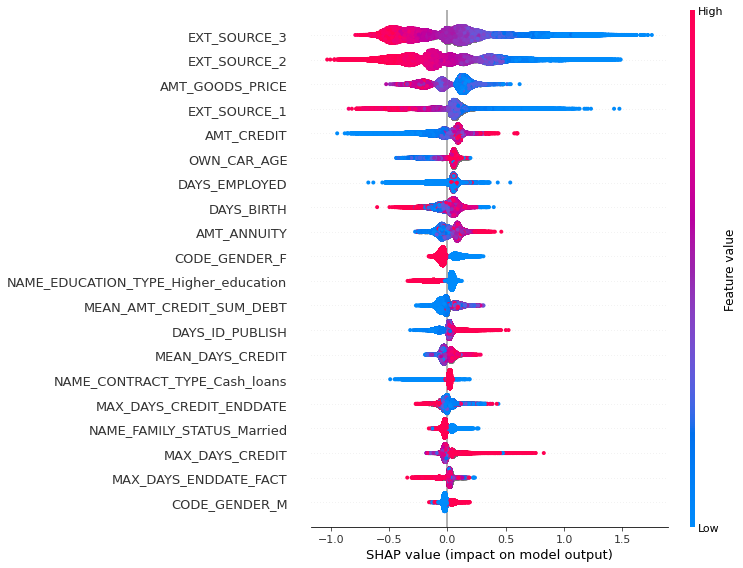

In [288]:
shap.summary_plot(shap_values[1], X_train)

## TODO

- Move bureau function to script
- Prefix feature names with source for easy reference
- Do iterations of PFI to drop features and re-train until X features left